In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

2025-01-13 12:50:54.762724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736769054.794293   73031 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736769054.804115   73031 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 12:50:54.838769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TRAIN_IMAGES = './data/food-5k/training/'
VAL_TIMAGES = './data/food-5k/validation/'
TEST_IMAGES = './data/food-5k/evaluation/'


In [3]:
# Initialize ResNet50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


data_gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_gen = data_gen.flow_from_directory(
    TRAIN_IMAGES,
    class_mode="binary", target_size=(224, 224), batch_size=32, shuffle=True
)

test_data_gen = data_gen.flow_from_directory(
    TEST_IMAGES,
    class_mode="binary", target_size=(224, 224), batch_size=32, shuffle=False  
)

# Training data
train_images, train_labels = [], [] # Initialize lists to store training images and labels

# Loop through the training data generator to collect all images and labels
for images, labels in train_data_gen:
    train_images.extend(images)
    train_labels.extend(labels)
    if len(train_images) >= train_data_gen.samples:
        break

# Convert the collected lists to NumPy arrays for further processing
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Extract features from training images using the base model
train_features = base_model.predict(train_images)

# Reshape the features into a 2D array suitable for input to the Random Forest classifier
train_features = train_features.reshape(train_features.shape[0], -1)

# Test data
test_images, test_labels = [], [] # Initialize lists to store test images and labels
image_paths = test_data_gen.filepaths # Get file paths of test images for reference in results

# Loop through the test data generator to collect all images and labels
for images, labels in test_data_gen:
    test_images.extend(images) # Append images to the test images list
    test_labels.extend(labels)
    if len(test_images) >= len(image_paths):
        break

# Convert the collected lists to NumPy arrays for further processing
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Extract features from test images using the base model
test_features = base_model.predict(test_images)

# Reshape the features into a 2D array suitable for input to the Random Forest classifier
test_features = test_features.reshape(test_features.shape[0], -1)

# Train Random Forest
# Create a Random Forest classifier with 100 trees 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training features and labels
rf.fit(train_features, train_labels)

# Predictions
# Use the trained classifier to predict labels for the test features
predictions = rf.predict(test_features)

# Generate results
# Map numeric labels to string labels for true and predicted values (e.g., "Food" or "Non-Food")
true_labels = ["Non-Food" if label == 1 else "Food" for label in test_labels]
predicted_labels = ["Non-Food" if pred == 1 else "Food" for pred in predictions]

# Create a DataFrame to store the image paths, true labels, and predicted labels
results = pd.DataFrame({
    "Image_Path": image_paths,
    "True_Label": true_labels,
    "Predicted_Label": predicted_labels
})

# Save the results to a CSV file for further analysis or review
results.to_csv("predictions_results.csv", index=False)



I0000 00:00:1736769059.174980   73031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5457 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


2025-01-13 12:51:17.881264: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1806336000 exceeds 10% of free system memory.
2025-01-13 12:51:19.877956: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1806336000 exceeds 10% of free system memory.
I0000 00:00:1736769084.651859   73183 service.cc:148] XLA service 0x7e85f4003a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736769084.651889   73183 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2025-01-13 12:51:24.808243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736769085.710776   73183 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-13 12:51:27.134161: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omi

 1/94 ━━━━━━━━━━━━━━━━━━━━ 15:49 10s/step

I0000 00:00:1736769091.784821   73183 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

2025-01-13 12:51:48.073962: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[24,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-13 12:51:48.676494: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[24,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForw

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step


2025-01-13 12:51:52.452171: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1204224000 exceeds 10% of free system memory.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

2025-01-13 12:52:08.283391: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-13 12:52:08.604019: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward"

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step


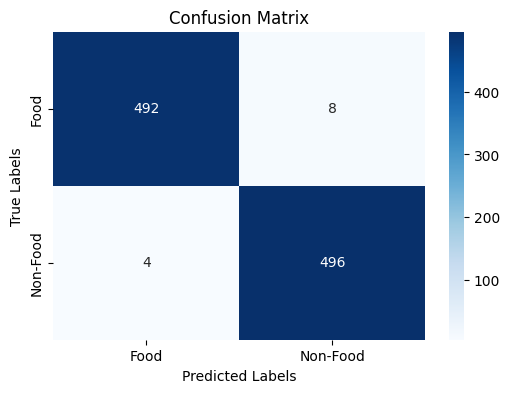

              precision    recall  f1-score   support

        Food       0.99      0.98      0.99       500
    Non-Food       0.98      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [4]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Food', 'Non-Food'], yticklabels=['Food', 'Non-Food'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels, predictions, target_names=['Food', 'Non-Food']))



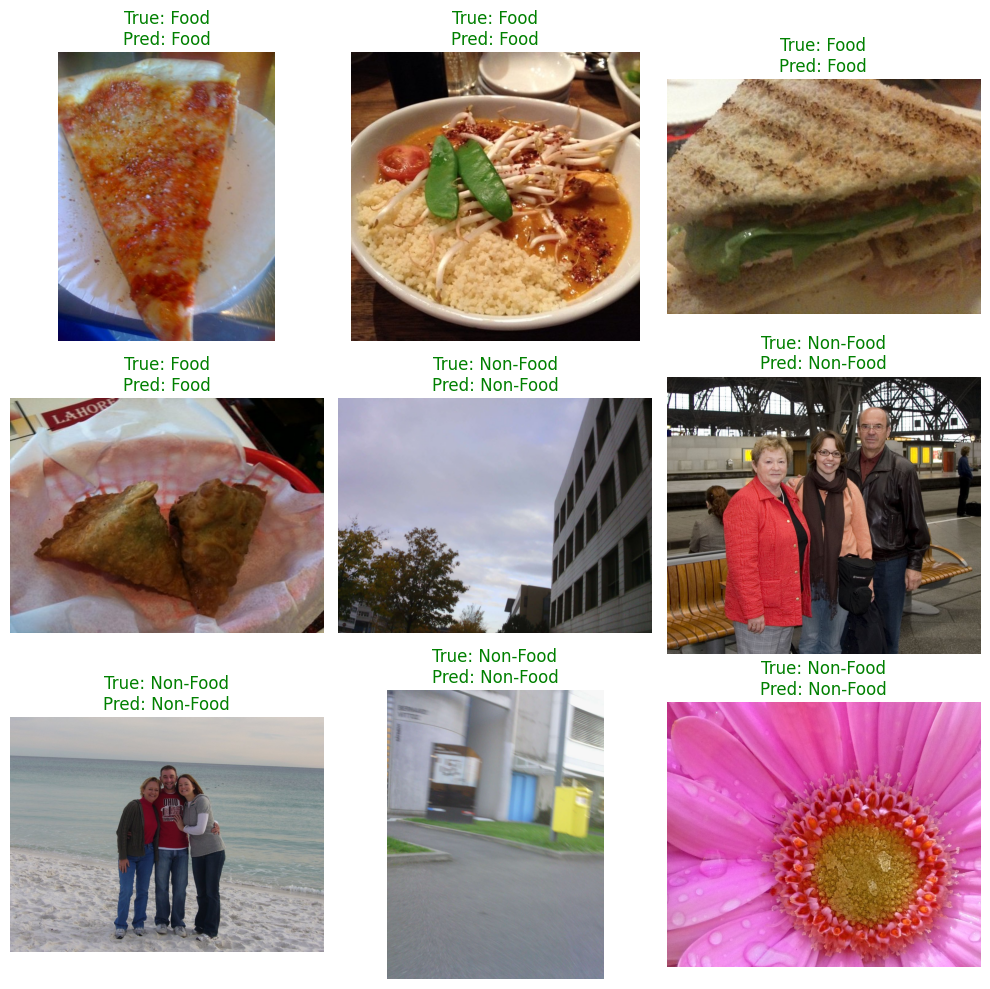

In [5]:
# Visualization of random images with true and predicted labels
plt.figure(figsize=(10, 10))

# Select 9 random indices from the results DataFrame
random_indices = random.sample(range(len(results)), 9)

# Loop over the 9 random indices to display the images
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    img = Image.open(results.iloc[idx]["Image_Path"])
    true_label = results.iloc[idx]["True_Label"]
    predicted_label = results.iloc[idx]["Predicted_Label"]

    # Set the title color to green if the prediction is correct, else red
    color = "green" if true_label == predicted_label else "red"
    
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.imshow(img) # Display the image
    plt.axis("off") # Remove axis for better visualization

# Adjust layout to ensure subplots don't overlap
plt.tight_layout()
plt.show()

In [6]:
import joblib

# Save the trained Random Forest model to a file
joblib.dump(rf, "./models/random_forest_model.pkl")
print("Random Forest model saved as random_forest_model1.pkl")


Random Forest model saved as random_forest_model1.pkl


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import joblib

# Load Random Forest model
rf_loaded = joblib.load("/Users/nadezdasemenova/MyDisk/NeuFische_Project/bootcamp/UMAMI/Project/random_forest_model.pkl")
print("Random Forest model loaded.")

# Initialize ResNet50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("ResNet50 model loaded.")

# Predict for a new image
image_path = "/Users/nadezdasemenova/MyDisk/NeuFische_Project/bootcamp/UMAMI/data/Food5K/training_extra/13.jpg"  # the path to the image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = preprocess_input(np.expand_dims(img_array, axis=0))  # Preprocess the image

# Extract features using ResNet50
features = base_model.predict(img_array) # Get feature predictions
features = features.reshape(1, -1)  # Reshape to a 2D array

# Make a prediction using Random Forest
prediction = rf_loaded.predict(features)
predicted_class = "Food" if prediction[0] == 0 else "Non-Food" # Interpret the prediction
print(f"Predicted class: {predicted_class}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nadezdasemenova/MyDisk/NeuFische_Project/bootcamp/UMAMI/Project/random_forest_model.pkl'